In [15]:
# create simple system to operate a dominoes game

# -- top level "API" for game --
# inputs:
# 1. number of players
# 2. maximum number of dominoes
# 3. rule for creating player agent, or preset list of agents
# operation:
# 1. distribute dominoes to each player randomly
# 2. create turn list
# 3. query players for their play (evaluate whether the play is valid and accept or reject it)
# 4. identify winner, track score, initiate new round until 0/0 is finished

# -- agent --
# 1. one-hot of dominoes in hand
# 2. one-hot of dominoes already played
# 3. multi-length vector, one input for each other player, containing: 1) how many dominoes in their hand, 2) whether they have a penny up, 3) how many turns until they play
# 4. number of turns until the agent plays
# 5. one-hot of dominoes available to play on 
# 6. dominoe played on last turn? 

# -- simple agents --
# 1. play random dominoe
# 2. play highest dominoe
# 3. play double-pair dominoe
# 4. RL agent...

# -- observation agents --
# 1. I can train an independent RL model to predict the points at the end of each game from the current game state and run that independently. 
#    This would work by feeding in the full game state, then having the network predict the value on the next turn, and then learn from the last turn moving backwards (with uncertainty etc.)
#    Then, I can teach this observer using games from crystallized agents, and update one agent to see how much better it performs than change. 
#    Additionally, this agent could maybe be integrated into the gameplay agents? 
# 2. Could train an RL model to predict what dominoes are in other agents hands based on what has been played, their line, and what is available...

# -- ideas for flexibility in terms of number of players --
# 1. the agent could process "own line", "opponent line", "dummy line" in an LSTM network in 3+ steps, where an additional one-hot input determines whose line is being valued. 
#    in this way, the LSTM network would learn to process opponent lines generally, and then just receive additional processing steps for valuation of each line 

In [ ]:
# to-do list
# 230628 -- I've completed the basic mechanics of the game, it works, and I can run games and develop agents now.
#
# Next: - read & think about how to train an agent to be smarter...
#       - I think I need an actor-critic model, where the critic is learning to predict outcomes based on game-state and action, and the actor is making decisions
#       - This is gonna be a bit hard and I'll need to read some papers to implement it intelligently.
#       - but...
#       - The simplest way is to: build one single network
#                                 "remember" the states and actions chosen throughout an entire hand
#                                 then use the final score as a teaching signal that propagates down to every action

# -- setup infinite gameplay so an agent can be initialized in a game once, and then learn for a very very long time... --

In [10]:
# Training Ideas:
# 1. Teach line-formation by penalizing actions based on whether there's another play available (can be within or across lines...)
# 2. Teach score estimation by training network to predict points in each other hand, using the uncertain naive estimate of (pointsLeft/numberOfPlayers*dominoesPerHand)? 
# 3. NOTE: Simple FF networks are pretty bad at estimating current hand value... they don't asymptote to perfect error even though it's just a dot product.

# Overall Ideas: 
# - The network has to take in the gamestate information as input and output a value function of each dominoe/location pairing (which is essentially the state-action table, or Q)
# - The network can estimate a value from the gamestate information independently. The value should be the expected score at the end of the game. 
# - Each time the network has to play, it can compare it's expected score at the beginning of it's turn with the expected score at the beginning of it's last turn as the TD error. 
# - Presumably, the network will get better and better at predicting the final score as it learns from the end-game scenarios...
# - Maybe I can pretrain it by using TrainingIdea#2 above, and it can learn how much to use it's own value estimation and the naive estimate? 

# -- Initial Push --
# Build an LSTM network that learns to predict the value of dominoes in each players hand based on the gamestate information (it steps each players turn)
# It is trained from omniscient information (the error function is the difference between the prediction and the true hand value)
# Idea: once this LSTM network is pretrained, it will be used as an input to the agent network for temporal difference learning.

In [56]:
%reload_ext autoreload
%autoreload 2

import random
import numpy as np
import matplotlib.pyplot as plt
import dominoesGameplay as dg
import dominoesAgents as da
import dominoesNetworks as dn
import dominoesFunctions as df
from tqdm import tqdm
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [4]:
# next steps: 
# 1. add game simulation engine to agents (or game?) to permit agents to sample gameState for a particular action
# 2. then, use the argmax action of future value to move the game forward

# -- also, now that it's training and gameplay time, it's probably a good idea to optimize the code now...
# -- regarding next step 1: 
# ------ convert most of the code within "doTurn()" to a standalone function that accepts the gameState and the next play as the inputs, and returns an updated gameState
# ------ then, this function can be fed into the agents and they can simulate what their turn options would do...


In [3]:
numPlayers = 4
highestDominoe = 9
numRounds = 1000
game = dg.dominoeGame(highestDominoe, numPlayers=numPlayers, defaultAgent=da.valueAgent0, device=device)
game.playGame(rounds=numRounds,withUpdates=True)
# game.initializeHand()

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [10:37<00:00,  1.57it/s]


In [42]:
# game.doTurn()

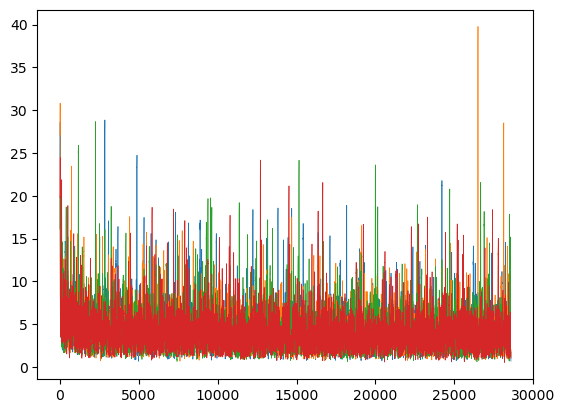

In [25]:
cfn = 19
convFilter = np.ones(cfn)/cfn
for agent in game.agents:
    plt.plot(np.convolve(np.array(np.abs(agent.storeSelfHandvalueError)),convFilter,mode='same'),linewidth=0.5)


In [9]:
x = np.eye(5)
print(x)

idxNextPlayerShift = np.mod(np.arange(5)-1,5)
print(idxNextPlayerShift)

print(x[idxNextPlayerShift])

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
[4 0 1 2 3]
[[0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]]


In [92]:
# print performance monitoring
print(game.prepareScoreTime[0]/game.prepareScoreTime[1])
print(game.initHandTime[0]/game.initHandTime[1])
print(game.presentGameStateTime[0]/game.presentGameStateTime[1])
print(game.agentPlayTime[0]/game.agentPlayTime[1])
print(game.processPlayTime[0]/game.processPlayTime[1])

0.0
5.336737632751465e-05
1.302783411681236e-05
3.3613891042093196e-05
1.0002245380520331e-05


In [77]:
numPlayers = 4
highestDominoe = 9
winnerCount = np.zeros(numPlayers)
scoreTally = np.zeros(numPlayers)
numGames = 300
numRounds = 9
game = dg.dominoeGame(highestDominoe, agents=(da.doubleAgent, da.greedyAgent, None, da.stupidAgent))
for _ in tqdm(range(numGames)):
    game.playGame(rounds=numRounds)
    # game.printResults()
    winnerCount[game.currentWinner]+=1
    scoreTally += game.currentScore
print(winnerCount)
print(scoreTally / numGames / numRounds)

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:11<00:00, 25.52it/s]

[216.  74.   9.   1.]
[ 7.36962963 10.34148148 17.77111111 24.62037037]


In [ ]:
game.playHand()
game.printResults()

Game has already finished
[[ 31  17  20   0]
 [ 98 155  98 128]
 [106 124 121 130]
 [127 139 108 109]
 [102 112 143 128]
 [123 103 147 114]
 [114 127 124 124]
 [130 123 110 128]
 [132 124 117 120]
 [137 125 136  97]]
[1100 1149 1124 1078]
The winner is agent: 3 with a score of 1078!


## Below this point I'm including some code blocks that make inspection of the gameplay and agent status easy... 

In [159]:
numPlayers = 4
highestDominoe = 9
game = dg.dominoeGame(highestDominoe, agents=(da.doubleAgent, da.greedyAgent, None, da.stupidAgent))
game.playGame()
game.printResults()

[[  0  25  57  20]
 [130  97 129 123]
 [136 104 106 135]
 [118 118 140 107]
 [ 83 136 124 142]
 [127 127 113 120]
 [133 114 120 122]
 [119 151 134  87]
 [122 132 116 123]
 [119 110 133 133]]
[1087 1114 1172 1112]
The winner is agent: 0 with a score of 1087!


In [153]:
numPlayers = 4
highestDominoe = 9
game = dg.dominoeGame(highestDominoe, agents=(da.doubleAgent, da.greedyAgent, None, da.stupidAgent))
game.playHand()
df.gameSequenceToString(game.dominoes, game.lineSequence, game.linePlayDirection, player=None, playNumber=None) #player=game.linePlayer, playNumber=game.linePlayNumber)
df.gameSequenceToString(game.dominoes, game.dummySequence, game.dummyPlayDirection, player=None, playNumber=None) #player=game.linePlayer, playNumber=game.linePlayNumber)

[' 9|7 ', ' 7|7 ', ' 7|5 ', ' 5|5 ', ' 5|4 ', ' 4|0 ', ' 0|0 ']
[' 9|5 ', ' 5|6 ', ' 6|7 ', ' 7|8 ', ' 8|4 ', ' 4|7 ', ' 7|3 ', ' 3|8 ', ' 8|2 ', ' 2|4 ']
[' 9|8 ', ' 8|0 ', ' 0|7 ', ' 7|1 ', ' 1|1 ', ' 1|5 ', ' 5|3 ', ' 3|2 ']
[' 9|2 ', ' 2|6 ', ' 6|3 ', ' 3|0 ', ' 0|5 ', ' 5|8 ', ' 8|1 ']
[' 9|6 ', ' 6|0 ', ' 0|9 ', ' 9|3 ', ' 3|3 ', ' 3|4 ', ' 4|4 ', ' 4|6 ', ' 6|6 ', ' 6|1 ', ' 1|4 ', ' 4|9 ', ' 9|1 ']


In [449]:
# Example of options list for current game (requires game.initializeHand() and game.presentGameState() to be run)
lineOptions, dummyOptions = game.agents[0].playOptions()
df.printDominoeList(lineOptions, game.agents[0].dominoes, name='line')
df.printDominoeList(dummyOptions, game.agents[0].dominoes, name='dummy:')
dominoe, location = game.agents[0].selectPlay()
print(f"Dominoe: {dominoe}, Location: {location}")

line 0: []
line 1: []
line 2: []
line 3: []
dummy: []
Dominoe: None, Location: None


In [207]:
# game details
game.lineSequence

[[], [], [1], []]

In [ ]:
# create random game states and then train a network to predict current hand score...
def generateRandomHand(dominoes, numDominoes, numPlayers, verboseOutput=False):
    numInHands = np.random.randint(numDominoes+1)
    idxInHands = np.random.choice(numDominoes,numInHands,replace=False)
    handIdx = np.random.randint(0, numPlayers, numInHands)
    played = np.full(numDominoes, True)
    myHand = np.full(numDominoes, False)
    otherHands = np.full(numDominoes, False)
    played[idxInHands]=False
    myHand[idxInHands[handIdx==0]] = True
    otherHands[idxInHands[handIdx>0]] = True
    myHandValue = np.sum(dominoes[myHand])
    otherHandValue = np.sum(dominoes[otherHands])
    if verboseOutput:
        return played, myHand, otherHands, myHandValue, otherHandValue
    networkInput = (np.concatenate((played, myHand))*1)
    networkOutput = np.array([myHandValue, otherHandValue])
    # networkInput = np.concatenate((np.sum(dominoes.T * played, axis=0), np.sum(dominoes.T * myHand, axis=0)))
    return networkInput, networkOutput

# played, myHand, otherHands, myHandValue, otherHandValue = generateRandomHand(dominoes, numDominoes, numPlayers, verboseOutput=True)
networkInput, networkOutput = generateRandomHand(dominoes, numDominoes, numPlayers)

numPlayers = 2
highestDominoe = 4
numDominoes = df.numberDominoes(highestDominoe)
dominoes = df.listDominoes(highestDominoe)

handValueNetwork = dn.handValueNetwork(numPlayers,numDominoes,highestDominoe)
handValueNetwork.to(device)

numIterations = 10000
target = np.zeros((numIterations, 2))
pred = np.zeros((numIterations, 2))
storeLoss = np.zeros(numIterations)

lossFunction = nn.SmoothL1Loss()
# optimizer = torch.optim.SGD(handValueNetwork.parameters(), lr=1e-2, momentum=0.5)
optimizer = torch.optim.Adadelta(handValueNetwork.parameters())

for ii in tqdm(range(numIterations)):
    networkInput, networkOutput = generateRandomHand(dominoes, numDominoes, numPlayers)
    target[ii] = np.copy(networkOutput)
    
    networkInput = torch.tensor(networkInput).to(device).float()
    networkOutput = torch.tensor(networkOutput).to(device).float()
    
    output = handValueNetwork(networkInput)
    
    loss = lossFunction(output, networkOutput)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    storeLoss[ii] = loss.item()
    pred[ii] = output.detach().cpu().numpy()
    
print(np.mean(storeLoss[-100:]))
fig,ax = plt.subplots(1,2,figsize=(7,3))
ax[0].plot(range(numIterations), storeLoss, linewidth=0.5)
ax[1].plot(range(numIterations), pred[:,0]-target[:,0])